In [ ]:
!pip install yfinance

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sc
plt.style.use('dark_background')

In [ ]:
def getReturns(stocks, start, end):
    data = yf.download(stocks, start, end)['Close']
    return data

stocks="GOLD BRK-B WMT UNH V CVX HD PFE"
start="2020-01-01"
end="2020-12-30"
data= getReturns(stocks, start, end)

In [3]:
tr_days=data.shape[0]
returns= data.pct_change()
mean_returns= returns.mean()
Cov=returns.cov()

In [4]:
returns

,BRK-B,CVX,GOLD,HD,PFE,UNH,V,WMT
Date,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,-0.009676,-0.003459,0.004327,-0.003323,-0.005365,-0.010120,-0.007953,-0.008828
2020-01-06,0.003581,-0.003388,-0.009693,0.004705,-0.001284,0.006942,-0.002162,-0.002036
2020-01-07,-0.004714,-0.012769,0.004350,-0.006547,-0.003344,-0.006037,-0.002643,-0.009265
2020-01-08,0.000310,-0.011423,-0.035192,0.014964,0.008000,0.021084,0.017118,-0.003432
...,...,...,...,...,...,...,...,...
2020-12-22,-0.007204,-0.020095,-0.021720,-0.003506,-0.017121,-0.003184,-0.015167,-0.012126
2020-12-23,0.010636,0.015766,0.013766,-0.000852,0.019053,0.007701,-0.002623,-0.006796
2020-12-24,0.010212,-0.004201,0.003066,0.004114,-0.004541,0.009479,0.016561,0.001955


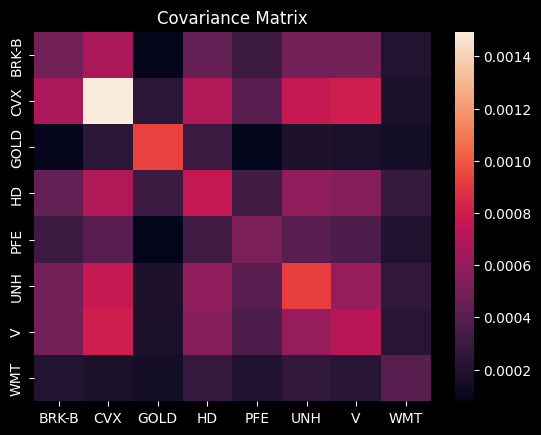

In [5]:
def Cov_mtrx(Cov):
    ax = sns.heatmap(Cov, cbar=True)
    plt.title("Covariance Matrix")
    plt.show()
Cov_mtrx(Cov)

In [6]:
def PortfolioPerformance(x, mean_returns, Cov, tr_days):
    returns= (mean_returns@x)*tr_days
    var=((x.T@Cov)@x)*tr_days
    std=np.sqrt(var)
    return returns, std


In [7]:
#Queremos maximizar el sharpe ratio, por lo tanto minimizaremos el -sharp ratio
#Para esto creamos la funcion
def SharpeRatio(x, mean_returns, Cov, tr_days):
    #Asumimos risk free rate=0
    returns, std= PortfolioPerformance(x, mean_returns, Cov, tr_days)
    return -returns/std


def max_SR(mean_returns, Cov, tr_days):
    num_assets= len(mean_returns)
    eq_cons= ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds=tuple((0,1) for j in range(num_assets))
    arg= (mean_returns, Cov, tr_days)
    sol = sc.optimize.minimize(fun=SharpeRatio, x0=np.ones(num_assets), args=arg,
                                method='SLSQP', bounds=bounds, constraints=eq_cons)
    return -sol['fun'], sol['x']

In [8]:

#print(max_SR(mean_returns, Cov, tr_days))
#return_MaxSR = PortfolioPerformance(max_SR(mean_returns, Cov, tr_days)[1], mean_returns, Cov, tr_days)[0]
#print(return_MaxSR)

In [9]:
#Minimizar la desviacion es lo mismo q minimizar la varianza
def PortfolioVar(x, mean_returns, Cov, tr_days):
    var= PortfolioPerformance(x, mean_returns, Cov, tr_days)[1]
    return var

def MinVar(mean_returns, Cov, tr_days):
    num_assets= len(mean_returns)
    arg= (mean_returns, Cov, tr_days)
    eq_cons= ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds=tuple((0,1) for j in range(num_assets))
    sol = sc.optimize.minimize(fun=PortfolioVar, x0=np.ones(num_assets), args=arg,
                                method='SLSQP', bounds=bounds, constraints=eq_cons)
    return sol['fun'], sol['x']

In [ ]:
MinVar(mean_returns, Cov, tr_days)

In [ ]:
#Minimizar la varianza dado target return
def returnConstr(x, mean_returns, Cov, tr_days):
    return PortfolioPerformance(x, mean_returns, Cov, tr_days)[0]

def Mark_port(mean_returns, Cov, tr_days, target):
    num_assets= len(mean_returns)
    arg= (mean_returns, Cov, tr_days)
    eq_cons= ({'type':'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type':'eq', 'fun': lambda x: returnConstr(x, mean_returns, Cov, tr_days) - target})
    bounds=tuple((0,1) for j in range(num_assets))
    sol = sc.optimize.minimize(fun=PortfolioVar, x0=np.ones(num_assets),
                               args=arg, method='SLSQP', bounds=bounds, constraints=eq_cons)
    return sol['fun'], sol['x']

a,b=Mark_port(mean_returns, Cov, tr_days, 0.16)
PortfolioPerformance(b, mean_returns, Cov, tr_days)[0]

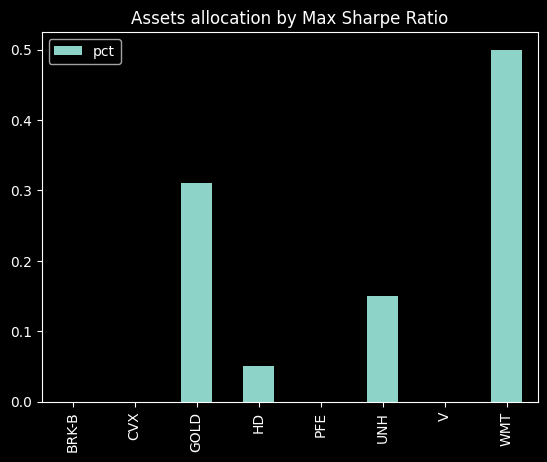

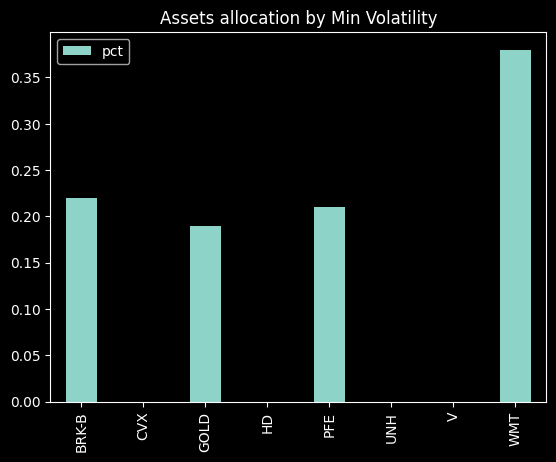

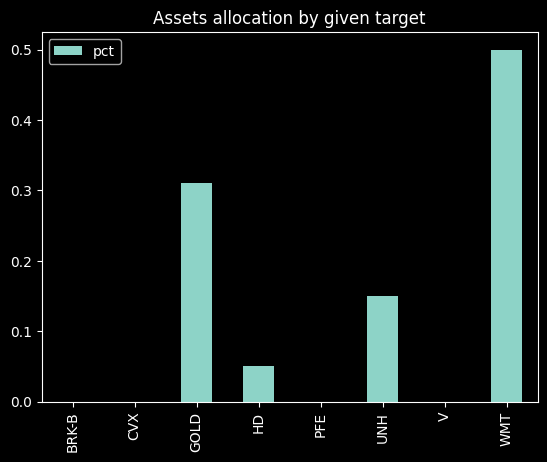

In [12]:
def maxSR_data(mean_returns, Cov, tr_days, graph): #Hacer que graph sea una parametro opcional
    SR= list(max_SR(mean_returns, Cov, tr_days))
    returns, std= PortfolioPerformance(SR[1], mean_returns, Cov, tr_days)
    SR[1]=np.round(SR[1], decimals=2)
    SR_df= pd.DataFrame(SR[1], index=mean_returns.index, columns=["pct"])
    return returns, std, SR_df

def MinVar_data(mean_returns, Cov, tr_days, graph):
    MV= list(MinVar(mean_returns, Cov, tr_days))
    returns, std= PortfolioPerformance(MV[1], mean_returns, Cov, tr_days)
    MV[1]=np.round(MV[1], decimals=2)
    SR_df= pd.DataFrame(MV[1], index=mean_returns.index, columns=["pct"])
    return returns, std, SR_df

def MarkPort_data(mean_returns, Cov, tr_days, target, graph): #Hacer que graph sea una parametro opcional
    Mk_P= list(Mark_port(mean_returns, Cov, tr_days, target))
    returns, std= PortfolioPerformance(Mk_P[1], mean_returns, Cov, tr_days)
    Mk_P[1]=np.round(Mk_P[1], decimals=2)
    SR_df= pd.DataFrame(Mk_P[1], index=mean_returns.index, columns=["pct"])
    return returns, std, SR_df

bar1=maxSR_data(mean_returns, Cov, tr_days, graph=False)[2].plot.bar(title="Assets allocation by Max Sharpe Ratio")
bar2=MinVar_data(mean_returns, Cov, tr_days, graph=False)[2].plot.bar(title="Assets allocation by Min Volatility")
target=0.27964
bar3 =MarkPort_data(mean_returns, Cov, tr_days, target, graph=False)[2].plot.bar(title="Assets allocation by given target")

In [13]:
def MarkPort_data(mean_returns, Cov, tr_days, target, graph): #Hacer que graph sea una parametro opcional
    Mk_P= list(Mark_port(mean_returns, Cov, tr_days, target))
    returns, std= PortfolioPerformance(Mk_P[1], mean_returns, Cov, tr_days)
    Mk_P[1]=np.round(Mk_P[1], decimals=2)
    SR_df= pd.DataFrame(Mk_P[1], index=mean_returns.index, columns=["pct"])
    return returns, std, SR_df

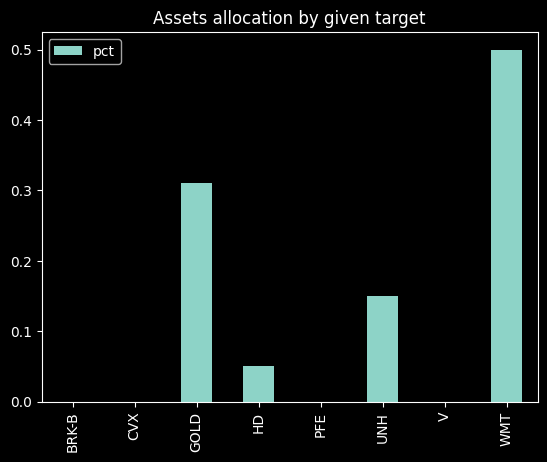

In [14]:
target=0.27964
bar =MarkPort_data(mean_returns, Cov, tr_days, target, graph=False)[2].plot.bar(title="Assets allocation by given target")

In [16]:
def efficient_frontier(mean_returns, Cov, tr_days):
    fig, ax=plt.subplots()
    y_targets=np.linspace(MinVar_data(mean_returns, Cov, tr_days, graph=False)[0]
                    , maxSR_data(mean_returns, Cov, tr_days, graph=False)[0],30)
    y2_targets=[]
    x_stds=[]
    x2_stds=[]
    for j in range(len(y_targets)):
        x_std = MarkPort_data(mean_returns, Cov, tr_days, y_targets[j], graph=False)[1]
        x_stds.append(x_std)

        y2_targets.append(-y_targets[j]+2*y_targets[0])
        x2_std = MarkPort_data(mean_returns, Cov, tr_days, y_targets[j], graph=False)[1]
        x2_stds.append(x_std)

    plt.plot(x_stds[-1],y_targets[-1] ,'*', color="red",label="Max Sharpe Ratio")
    plt.plot(x_stds[0],y_targets[0] ,'*', color="green",label="Min Risk")
    plt.plot(x_stds, y_targets, label="Optimal Portfolios")
    plt.plot(x2_stds, y2_targets, label="Min Returns Porfolios")
    ax.set_xlabel("Risk")
    ax.set_ylabel("Return")
    plt.legend()
    plt.show()

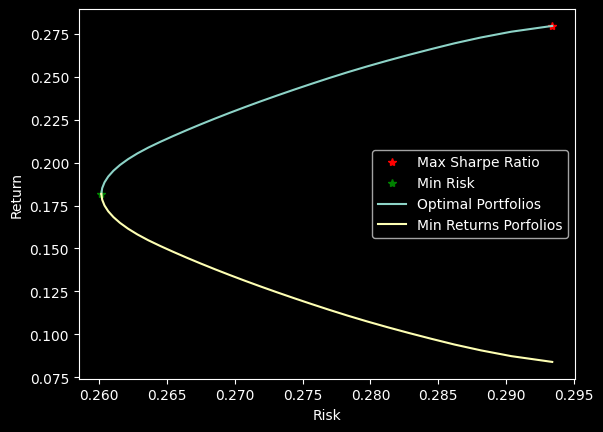

In [17]:
efficient_frontier(mean_returns, Cov, tr_days)